**Dataset**: Credit card applications data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/)

**Task**: Fraud detection on an unlabeled dataset leveraing both unsupervised and supervised deep learning techniques such as Self Organizing Map (SOM) and Artificial Neural Network (ANN).

In [1]:
## imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf

C:\Users\abhin\anaconda3\envs\nlp_course\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\abhin\anaconda3\envs\nlp_course\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\abhin\anaconda3\envs\nlp_course\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\abhin\anaconda3\envs\nlp_course\lib\site-packages

In [2]:
## load dataset
data = pd.read_csv('Credit_Card_Applications.csv')
data.head(10)

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.460,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.000,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.750,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.500,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.170,2,6,4,1.960,1,1,14,0,2,60,159,1
5,15571121,0,15.83,0.585,2,8,8,1.500,1,1,2,0,2,100,1,1
6,15726466,1,17.42,6.500,2,3,4,0.125,0,0,0,0,2,60,101,0
7,15660390,0,58.67,4.460,2,11,8,3.040,1,1,6,0,2,43,561,1
8,15663942,1,27.83,1.000,1,2,8,3.000,0,0,0,0,2,176,538,0
9,15638610,0,55.75,7.080,2,4,8,6.750,1,1,3,1,2,100,51,0


In [3]:
## feature label split
X = data.iloc[:,:-1].values ## keeping customer id to identify fraud instances later from the original dataset
y = data.iloc[:,-1].values

In [4]:
## feature scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

In [5]:
X.shape

(690, 15)

In [6]:
y[:5]

array([0, 0, 0, 1, 1], dtype=int64)

In [7]:
from minisom import MiniSom
som = MiniSom(x=10, y=10, input_len= 15, sigma= 1.0, learning_rate = 0.01) 
## sigma-->radius of neighborhoods in the SOM grid
som.random_weights_init(X) ## initialize random weight for each SOM node
som.train_random(data = X, num_iteration = 100)

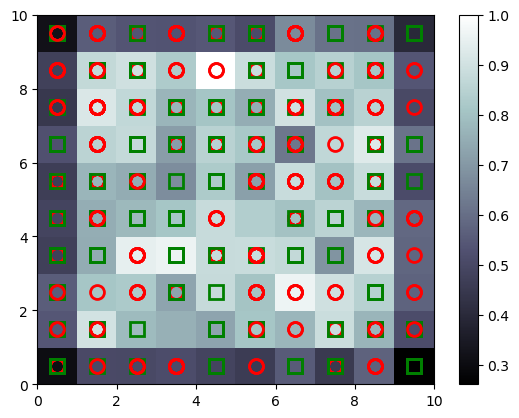

red --> fraud that got approval, green --> fraud that did not get approval, rest --> not frauds


In [8]:
from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T) ## som.distance_map() --> Mean Interneuron Distance (MID) for each winning node identified by SOM
colorbar() ## to reference MID against colored grid
## Big value of MID --> nodes are outliers in their neighborhoods (defined by radius) --> outliers --> fraud
markers = ['o', 's']
colors = ['r', 'g']
for i, x in enumerate(X): ## i-->index, x-->feature_vector
    w = som.winner(x) ## w --> winning node for feature vector at index i
    plot(w[0] + 0.5, ## x coordinate of center of winning SOM node
         w[1] + 0.5, ## y coordinate of center of winning SOM node
         markers[y[i]],
         markeredgecolor = colors[y[i]], ## r --> approved (high priority fraud), g --> not approved (preventable fraud)
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
show()

print('red --> fraud that got approval, green --> fraud that did not get approval, rest --> not frauds')

**Important**: The neuron at (1,4) has high Mean Interneuron Distance (MID), meaning it is an outlier (i.e. potential fraud). Also, the cluster represented by that neuron has both approved and un-approved credit cards, meaning some potential frauds have been issued credit cards. The next task is to find all samples represented by cluster neurons with high Mean Interneuron Distance (MID).

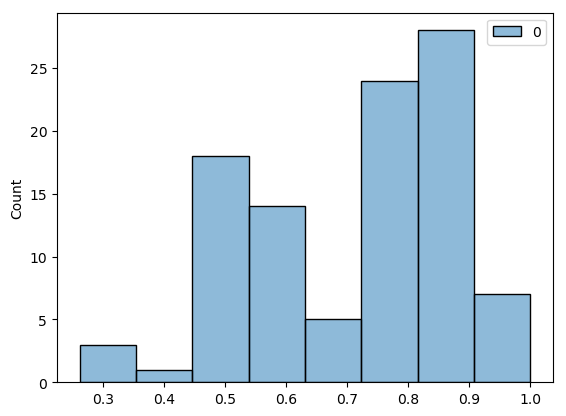

In [9]:
## plotting a histogram of Mean Interneuron Distance for the SOM cluster neurons

sns.histplot(data=som.distance_map().reshape(100,1))

In [10]:
threshold = 0.5

In [11]:
## get all cluster neurons with MID >= threshold

fraud_clusters = list()

for x,y in zip(np.where(som.distance_map()>=threshold)[0], np.where(som.distance_map()>=0.9)[1]):
    fraud_clusters.append((x,y))
    
fraud_clusters

[(0, 1), (0, 7), (0, 3), (1, 3), (1, 8), (1, 2), (1, 3), (1, 6)]

In [12]:
## mappings --> each cluster mapped to corresponding samples
mappings = som.win_map(X)

In [13]:
frauds = list()

for cluster in fraud_clusters:
    cluster_frauds = [int(x) for x in scaler.inverse_transform(mappings[cluster])[:,0]]
    frauds.extend(cluster_frauds)
    
frauds = np.array(frauds)
frauds

array([15603683, 15659100, 15713983, 15763194, 15809909, 15608595,
       15761158, 15711742, 15666166, 15605872, 15665087, 15627699,
       15622729, 15707681, 15598586, 15701738, 15690169, 15631685,
       15571081, 15630592, 15589541, 15621244, 15632789, 15567834,
       15591035, 15608804, 15611189, 15698522, 15607986, 15631685,
       15571081, 15630592, 15589541, 15767264, 15719940, 15815040,
       15761733, 15770995, 15736399, 15766734, 15667934])

In [14]:
len(frauds)

41

**Important**: After starting with an unsupervised learning technique (SOMs), we have found 14 potential frauds in our dataset without depending on a label. However, in order to make our system more robust, we can use the frauds we've discovered to create a label for our dataset, and further train an Artificial Neural Network (ANN) with the new information to attain higher accuracy in fraud detection.

In [15]:
## label the data
data['Fraud'] = data['CustomerID'].apply(lambda x: 1 if x in frauds else 0)
data['Fraud'].value_counts()

0    653
1     37
Name: Fraud, dtype: int64

In [16]:
data.head(10)

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class,Fraud
0,15776156,1,22.08,11.460,2,4,4,1.585,0,0,0,1,2,100,1213,0,0
1,15739548,0,22.67,7.000,2,8,4,0.165,0,0,0,0,2,160,1,0,0
2,15662854,0,29.58,1.750,1,4,4,1.250,0,0,0,1,2,280,1,0,0
3,15687688,0,21.67,11.500,1,5,3,0.000,1,1,11,1,2,0,1,1,0
4,15715750,1,20.17,8.170,2,6,4,1.960,1,1,14,0,2,60,159,1,0
5,15571121,0,15.83,0.585,2,8,8,1.500,1,1,2,0,2,100,1,1,0
6,15726466,1,17.42,6.500,2,3,4,0.125,0,0,0,0,2,60,101,0,0
7,15660390,0,58.67,4.460,2,11,8,3.040,1,1,6,0,2,43,561,1,0
8,15663942,1,27.83,1.000,1,2,8,3.000,0,0,0,0,2,176,538,0,0
9,15638610,0,55.75,7.080,2,4,8,6.750,1,1,3,1,2,100,51,0,0


In [17]:
## feature label split

X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

In [18]:
## train test split

from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(test_size=0.3, random_state=27)

for train_idx, test_idx in sss.split(X,y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

In [19]:
## mean(y_train) = 0.5 --> perfectly balanced classes
np.mean(y_train)

0.053830227743271224

In [20]:
## normalization

from sklearn.preprocessing import MinMaxScaler

feature_scaler = MinMaxScaler(feature_range=(0,1))

feature_scaler.fit(X_train)
X_train = feature_scaler.transform(X_train)
X_test = feature_scaler.transform(X_test)

In [21]:
## model building

model = tf.keras.models.Sequential() ## instantiation

## layers
model.add(tf.keras.layers.Dense(units=10*X.shape[1], activation=tf.nn.leaky_relu, input_shape=(15,)))
model.add(tf.keras.layers.Dropout(rate=0.30))

model.add(tf.keras.layers.Dense(units=20*X.shape[1], activation=tf.nn.leaky_relu))
model.add(tf.keras.layers.Dropout(rate=0.30))

model.add(tf.keras.layers.Dense(units=30*X.shape[1], activation=tf.nn.leaky_relu))
model.add(tf.keras.layers.Dropout(rate=0.50))

model.add(tf.keras.layers.Dense(units=20*X.shape[1], activation=tf.nn.leaky_relu))
model.add(tf.keras.layers.Dropout(rate=0.30))

model.add(tf.keras.layers.Dense(units=10*X.shape[1], activation=tf.nn.leaky_relu))
model.add(tf.keras.layers.Dropout(rate=0.30))

## output
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

## compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 150)               2400      
_________________________________________________________________
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               45300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 450)               135450    
_________________________________________________________________
dropout_2 (Dropout)          (None, 450)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               135300    
__________

In [23]:
history = model.fit(x=X_train, y=y_train, epochs=100, batch_size=32, validation_data=[X_test, y_test])

Train on 483 samples, validate on 207 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
483/483 [==============================] - 1s 2ms/sample - loss: 0.3971 - acc: 0.8861 - val_loss: 0.2065 - val_acc: 0.9469
Epoch 2/100
483/483 [==============================] - 0s 309us/sample - loss: 0.1996 - acc: 0.9462 - val_loss: 0.1971 - val_acc: 0.9469
Epoch 3/100
483/483 [==============================] - 0s 320us/sample - loss: 0.1937 - acc: 0.9462 - val_loss: 0.1931 - val_acc: 0.9469
Epoch 4/100
483/483 [==============================] - 0s 316us/sample - loss: 0.1825 - acc: 0.9462 - val_loss: 0.1874 - val_acc: 0.9469
Epoch 5/100
483/483 [==============================] - 0s 313us/sample - loss: 0.1678 - acc: 0.9462 - val_loss: 0.2016 - val_acc: 0.9517
Epoch 6/100
483/483 [==============================] - 0s 303us/sample - loss: 0.1642 - acc: 0.9524 - val_loss: 0.1986 - val_acc: 0.9517
Epoch 7/100
483/483 [==============================] - 0s 318us/sample - loss: 0.1975 

483/483 [==============================] - 0s 300us/sample - loss: 0.0606 - acc: 0.9648 - val_loss: 0.2573 - val_acc: 0.9565
Epoch 59/100
483/483 [==============================] - 0s 302us/sample - loss: 0.0500 - acc: 0.9731 - val_loss: 0.2504 - val_acc: 0.9614
Epoch 60/100
483/483 [==============================] - 0s 302us/sample - loss: 0.0746 - acc: 0.9648 - val_loss: 0.2392 - val_acc: 0.9662
Epoch 61/100
483/483 [==============================] - 0s 319us/sample - loss: 0.0478 - acc: 0.9710 - val_loss: 0.2419 - val_acc: 0.9662
Epoch 62/100
483/483 [==============================] - 0s 311us/sample - loss: 0.0582 - acc: 0.9752 - val_loss: 0.2242 - val_acc: 0.9614
Epoch 63/100
483/483 [==============================] - 0s 315us/sample - loss: 0.0744 - acc: 0.9689 - val_loss: 0.2277 - val_acc: 0.9662
Epoch 64/100
483/483 [==============================] - 0s 312us/sample - loss: 0.0567 - acc: 0.9710 - val_loss: 0.2117 - val_acc: 0.9710
Epoch 65/100
483/483 [=========================

C:\Users\abhin\anaconda3\envs\nlp_course\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


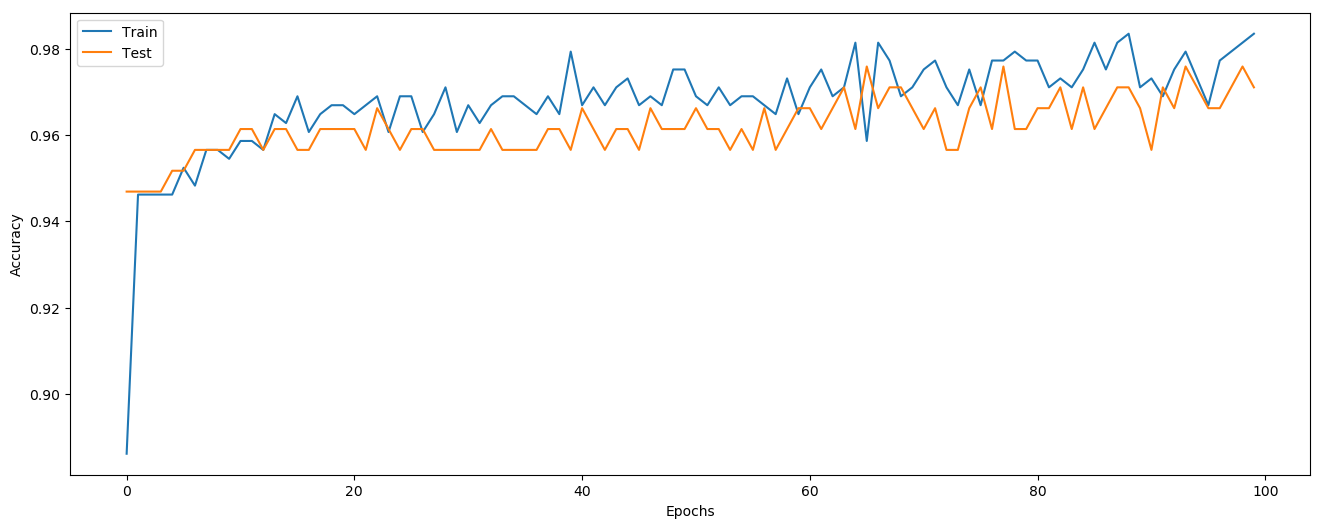

In [24]:
## plotting accuracy over epochs

plt, ax = plt.subplots(figsize=(16,6))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend(['Train', 'Test'])

plt.show()

In [25]:
from sklearn.metrics import classification_report, precision_score, recall_score

In [26]:
preds = model.predict_classes(X_test)

In [27]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       196
           1       0.86      0.55      0.67        11

    accuracy                           0.97       207
   macro avg       0.92      0.77      0.83       207
weighted avg       0.97      0.97      0.97       207



In [28]:
precision_score(y_test, preds)

0.8571428571428571

In [29]:
recall_score(y_test, preds)

0.5454545454545454

In [30]:
tf.keras.models.save_model(model, 'FraudDetector_acc97_precision86_recall55_epochs100.h5')